# Imports

In [81]:
import itertools
import math
import pandas as pd
import json
import os
import glob

from tqdm import tqdm
import seaborn as sns

import screed
import sklearn

%matplotlib inline

In [2]:
mouse_busco_dir = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse'    
human_busco_dir = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human'    


NameError: name 'filename' is not defined

# Get ids of "good" reads to use for classification

## Subset to only reads from complete protein sequences -- *will not change with input species*

could maybe write these ids to file

In [43]:
uniprot_protein_starts_with_m = []

with screed.open('/home/olga/data_sm/kmer-hashing/quest-for-orthologs/data/2019/Eukaryota/UP000005640_9606.fasta') as records:
    for record in records:
        if record['sequence'].startswith("M"):
            uniprot_protein_starts_with_m.append(record['name'].split()[0])
print('uniprot_protein_starts_with_m', len(uniprot_protein_starts_with_m))


uniprot_dna_starts_with_atg = []
with screed.open('/home/olga/data_sm/kmer-hashing/quest-for-orthologs/data/2019/Eukaryota/UP000005640_9606_DNA.fasta') as records:
    for record in records:
        if record['sequence'].startswith("ATG"):
            uniprot_dna_starts_with_atg.append(record['name'].split()[0])
print('uniprot_dna_starts_with_atg', len(uniprot_dna_starts_with_atg))

uniprot_protein_starts_with_m 20483
uniprot_dna_starts_with_atg 20336


In [50]:
uniprot_dna_starts_with_atg[:3]

['tr|A0A024R161|ENSP00000363412',
 'tr|A0A024R1R8|ENSP00000491117',
 'sp|A0A024RBG1|ENSP00000338352']

## Read gold standard reading frame file

In [145]:
parquet = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/true_reading_frames.parquet'

true_coding_frame = pd.read_parquet(parquet)
# Create just a series (single column) from this
true_coding_frame = true_coding_frame['is_coding']
true_coding_frame.head()

read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=1      True
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=2     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=3     False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-1    False
read1/tr|A0A024R1R8|ENSP00000491117;mate1Start:1;mate2Start:1__frame=-2    False
Name: is_coding, dtype: bool

# Read coding score csvs

## Add read_id_frame and is_coding for computing metrics

In [75]:
def add_read_id_frame_and_is_coding(df):
    df['read_id_frame'] = df.read_id.astype(str) + '__frame=' + df.translation_frame.astype(str)
    df['is_coding'] = df['category'] == "Coding"
    return df

## Get human busco mammalia reads

In [111]:
human_busco_mammalia = pd.read_csv('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/busco_mammalia_human_uniprot_ids.csv')
print(human_busco_mammalia.shape)
human_busco_mammalia.head()

(22539, 3)


,source__uniprot_id,source__id_type,source__db_id
0,P61981,OrthoDB,1176818at2759
1,P27348,OrthoDB,1176818at2759
2,P30443,OrthoDB,1390181at2759
3,Q96QU6,OrthoDB,1156861at2759
4,P10321,OrthoDB,1390181at2759


## Function to read coding scores consistently

In [130]:
def read_translate_csvs(globber, species=None, 
                        human_busco_mammalia=human_busco_mammalia, 
                        uniprot_dna_starts_with_atg=uniprot_dna_starts_with_atg, 
                        true_coding_frame=true_coding_frame):
    dfs = []
    
    for filename in tqdm(glob.glob(globber)):
        dirname = os.path.dirname(filename)
        parent_dir = os.path.basename(dirname)
        molecule_, ksize_ = parent_dir.split('_')
        molecule = molecule_.split('-')[1]
        ksize = int(ksize_.split('-')[1])
        
        df = pd.read_csv(filename)
        df['alphabet'] = molecule
        df['ksize'] = ksize
        df['species'] = species 
        df = add_read_id_frame_and_is_coding(df)
        
        # Get only reads generated from busco mammalia data
        df['protein_id'] = df['read_id'].map(lambda x: x.split('/')[1].split(';')[0])
        df['uniprot_id'] = df['protein_id'].str.split('|').str[1]
        df = df.query('uniprot_id in @human_busco_mammalia.source__uniprot_id')
        
        # Get only reads from transcripts starting with ATG and no Ns
        df = df.query('protein_id in @uniprot_dna_starts_with_atg')
        
        # Only use reads and frames in the gold standard data
        df = df.query('read_id_frame in @true_coding_frame.index')
        
        # Set the read id and frame as the row names
        df = df.set_index('read_id_frame')

        dfs.append(df)
    concatenated = pd.concat(dfs, ignore_index=False)
    concatenated = concatenated.sort_index()
    return concatenated

## Read human coding scores

In [146]:
! ls -lha $human_busco_dir/translate/molecule-dayhoff_ksize-10/

total 1.4G
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:30 .
drwxr-xr-x 48 olga czb 8.0K Sep 30 17:54 ..
-rw-r--r--  1 olga czb 181M Sep 22 18:30 Homo_sapiens_9606_qfo_dna_01__molecule-dayhoff_ksize-10__coding_reads_nucleotides.fasta
-rw-r--r--  1 olga czb 109M Sep 22 18:30 Homo_sapiens_9606_qfo_dna_01__molecule-dayhoff_ksize-10__coding_reads_peptides.fasta
-rw-r--r--  1 olga czb 812M Sep 22 18:30 Homo_sapiens_9606_qfo_dna_01__molecule-dayhoff_ksize-10__coding_scores.csv
-rw-r--r--  1 olga czb 2.0K Sep 22 18:30 Homo_sapiens_9606_qfo_dna_01__molecule-dayhoff_ksize-10__coding_summary.json
-rw-r--r--  1 olga czb 321M Sep 22 18:30 Homo_sapiens_9606_qfo_dna_01__molecule-dayhoff_ksize-10__noncoding_reads_nucleotides.fasta


In [131]:
%%time

human_busco_dir = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human'    
!ls -lha $human_busco_dir
human_scores = read_translate_csvs(
    f'{human_busco_dir}/translate/*/*.csv', 
    species='human',
    human_busco_mammalia=human_busco_mammalia, 
    uniprot_dna_starts_with_atg=uniprot_dna_starts_with_atg, 
    true_coding_frame=true_coding_frame
)
print(human_scores.shape)
human_scores.head()

total 51M
drwxr-xr-x  8 olga czb 4.0K Sep 25 19:08 .
drwxr-xr-x  9 olga czb 4.0K Sep 29 08:47 ..
drwxr-xr-x  2 olga czb 8.0K Sep 22 18:43 blastp
-rw-r--r--  1 olga czb  51M Sep 25 19:08 correct_reading_frames.csv
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:26 MultiQC
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:26 ncbi_refseq
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:43 pipeline_info
drwxr-xr-x  2 olga czb 8.0K Sep 22 18:26 sencha
drwxr-xr-x 48 olga czb 8.0K Sep 29 08:05 translate



100%|██████████| 46/46 [38:28<00:00, 50.18s/it]


(127187424, 12)
CPU times: user 53min 7s, sys: 4min 10s, total: 57min 18s
Wall time: 57min 47s


In [132]:
human_scores.head()

,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,31,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,19,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,13,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,27,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,24,human,False,sp|O43295|ENSP00000373347,O43295


### Write concatenated n frames per read, categorization to file

In [140]:
human_scores.to_parquet('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-human/translate/coding_scores.parquet')

## Read mouse coding scores

In [134]:
%%time

mouse_busco_dir = '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse'    
!ls -lha $mouse_busco_dir
mouse_scores = read_translate_csvs(
    f'{mouse_busco_dir}/translate/*/*.csv', 
    species='mouse'
    human_busco_mammalia=human_busco_mammalia, 
    uniprot_dna_starts_with_atg=uniprot_dna_starts_with_atg, 
    true_coding_frame=true_coding_frame
)
print(mouse_scores.shape)
mouse_scores.head()

total 19K
drwxr-xr-x  8 olga czb 4.0K Sep 22 18:48 .
drwxr-xr-x  9 olga czb 4.0K Sep 29 08:47 ..
drwxr-xr-x  2 olga czb 8.0K Sep 22 19:00 blastp
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:44 MultiQC
drwxr-xr-x  2 olga czb 4.0K Sep 22 18:44 ncbi_refseq
drwxr-xr-x  2 olga czb 4.0K Sep 22 19:00 pipeline_info
drwxr-xr-x  2 olga czb 8.0K Sep 22 18:44 sencha
drwxr-xr-x 48 olga czb 4.0K Sep 30 10:48 translate



100%|██████████| 46/46 [38:11<00:00, 49.81s/it]


(127187424, 12)
CPU times: user 53min 44s, sys: 4min 5s, total: 57min 50s
Wall time: 57min 59s


In [135]:
mouse_scores.head()

,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,31,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,19,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,13,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,27,mouse,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,24,mouse,False,sp|O43295|ENSP00000373347,O43295


In [136]:
human_scores.head()

,read_id,jaccard_in_peptide_db,n_kmers,category,translation_frame,filename,alphabet,ksize,species,is_coding,protein_id,uniprot_id
read_id_frame,,,,,,,,,,,,
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,31,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,dayhoff,19,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,13,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,27,human,False,sp|O43295|ENSP00000373347,O43295
read100001/sp|O43295|ENSP00000373347;mate1:1283-1432;mate2:1391-1540__frame=-1,read100001/sp|O43295|ENSP00000373347;mate1:128...,NaN,NaN,Translation frame has stop codon(s),-1,Homo_sapiens_9606_qfo_dna_01.fq.gz,protein,24,human,False,sp|O43295|ENSP00000373347,O43295


In [137]:
human_scores.shape

(127187424, 12)

In [138]:
mouse_scores.shape

(127187424, 12)

### Check that human and mouse are not equal

In [139]:
(human_scores.jaccard_in_peptide_db == mouse_scores.jaccard_in_peptide_db).all()

False

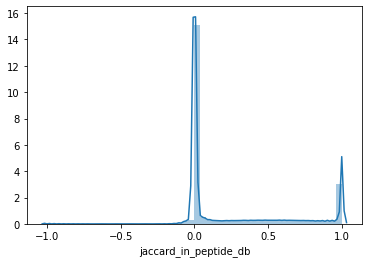

In [143]:
jaccard_diff = human_scores.jaccard_in_peptide_db.subtract(mouse_scores.jaccard_in_peptide_db)
sns.distplot(jaccard_diff.dropna())

### Write concatenated n frames per read, categorization to file

In [141]:
mouse_scores.to_parquet('/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse/translate/coding_scores.parquet')

In [ ]:
ls -lha '/mnt/ibm_sm/home/olga/pipeline-results/human-simulated/nf-predictorthologs--busco-mammalia-mouse/translate/coding_scores.parquet'